<a href="https://colab.research.google.com/github/swilsonmfc/trees/blob/master/AdaBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boosting

![](https://www.behavioraleconomics.com/wp-content/uploads/2018/12/elephants-1-1.png)

# Setup

In [3]:
!pip install kaggle

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Kaggle

In [5]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [7]:
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d usdot/flight-delays

 95% 181M/191M [00:03<00:00, 53.4MB/s]
100% 191M/191M [00:03<00:00, 60.8MB/s]


In [9]:
!ls

flight-delays.zip  sample_data


In [10]:
!unzip flight-delays.zip

Archive:  flight-delays.zip
  inflating: airlines.csv            
  inflating: airports.csv            
  inflating: flights.csv             


# Data

In [11]:
flight_df  = pd.read_csv('./flights.csv')
airport_df = pd.read_csv('./airports.csv')
airline_df = pd.read_csv('./airlines.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
flight_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
airport_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [14]:
airline_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


# Processing
* Trim down the dataset for this example notebook
* We're emphasizing and looking at boosting rather than trying to optimize the accuracy rate
* Three simplifications
 * Trim features
 * Drop missing
 * Downsample to equal classes and smaller size

## Features

In [15]:
keepCols = ['MONTH',
            'DAY_OF_WEEK',
            'AIRLINE',
            'ORIGIN_AIRPORT',
            'DESTINATION_AIRPORT',
            'SCHEDULED_DEPARTURE',
            'SCHEDULED_ARRIVAL',
            'SCHEDULED_TIME',
            'DISTANCE',
            'ARRIVAL_DELAY',
            'CANCELLED'
]
df = flight_df[keepCols].copy()

## Missing Data
* We have a small amount of missing arrival delays
* Rather than impute them to mean / median we'll drop them for simplicity

In [16]:
missing_df = pd.DataFrame(df.isna().mean().round(4) * 100)
missing_df.reset_index().rename(columns={'index': 'Feature', 0: 'Percent Missing'})

,Feature,Percent Missing
0,MONTH,0.00
1,DAY_OF_WEEK,0.00
2,AIRLINE,0.00
3,ORIGIN_AIRPORT,0.00
4,DESTINATION_AIRPORT,0.00
5,SCHEDULED_DEPARTURE,0.00
6,SCHEDULED_ARRIVAL,0.00
7,SCHEDULED_TIME,0.00
8,DISTANCE,0.00
9,ARRIVAL_DELAY,1.81


In [17]:
df = df.dropna()

## Balance Classes

In [18]:
delay  = df[df.ARRIVAL_DELAY > 15].sample(500000, replace=True, random_state=40)
ontime = df[df.ARRIVAL_DELAY <= 15].sample(500000, random_state=40)
df = pd.concat([delay, ontime])

In [19]:
df['CLASS'] = np.where(df.ARRIVAL_DELAY <= 15, 'ONTIME', 'DELAY')

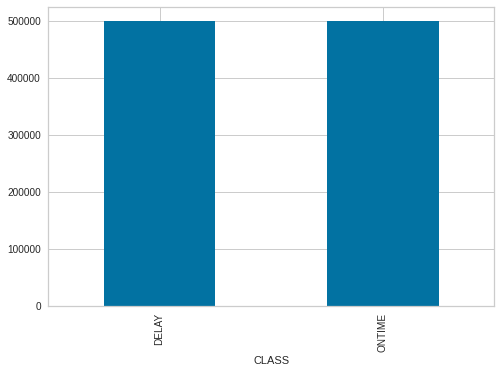

In [20]:
df.groupby('CLASS').size().plot.bar()

# EDA

## Top Arrival Airports & Airlines

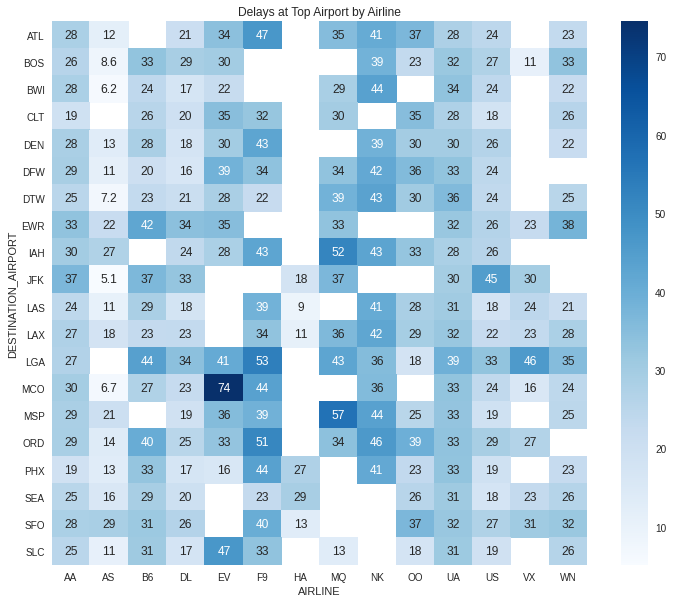

In [21]:
top = 20
topAirports = df.groupby('DESTINATION_AIRPORT').size() \
    .sort_values(ascending=False) \
    .head(top) \
    .index \
    .tolist()

pvt = df[df.DESTINATION_AIRPORT.isin(topAirports)] \
    .groupby(['AIRLINE', 'DESTINATION_AIRPORT']) \
    .agg({'ARRIVAL_DELAY': 'mean'}) \
    .reset_index() \
    .pivot(index='DESTINATION_AIRPORT', columns='AIRLINE', values='ARRIVAL_DELAY')

plt.figure(figsize=(12,10))
plt.title('Delays at Top Airport by Airline')
sns.heatmap(pvt, cmap='Blues', annot=True)
plt.yticks(rotation=0);

## Airline Delay Distribution

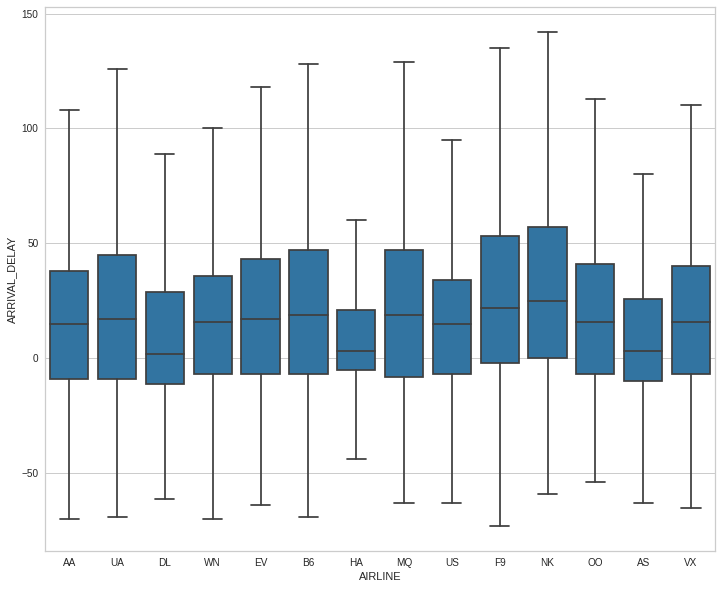

In [22]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.AIRLINE, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            color='#1f77b4');

## Delays by Month

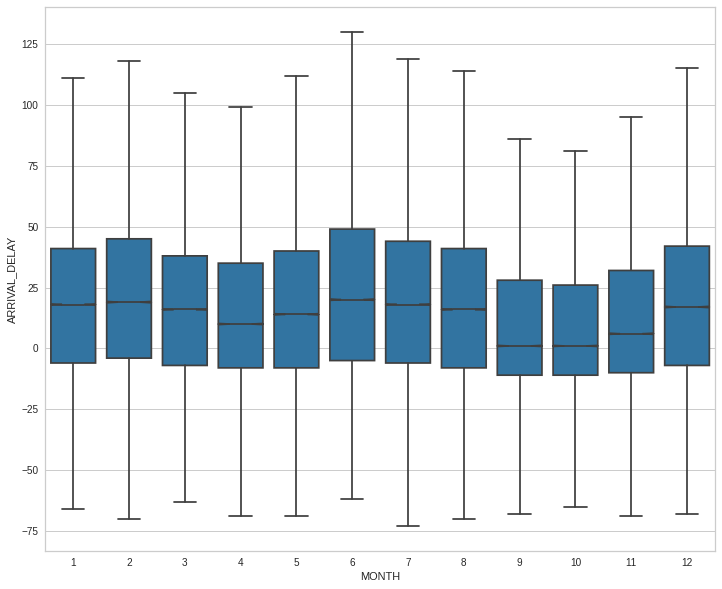

In [23]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.MONTH, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            notch=True,
            color='#1f77b4');

## Delays by Day of Week

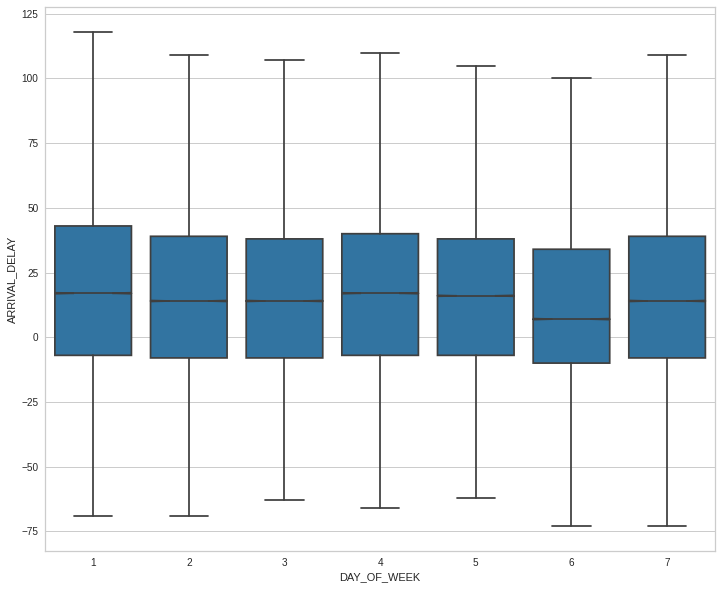

In [24]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.DAY_OF_WEEK, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            notch=True,
            color='#1f77b4');

## Distance

<Figure size 1080x864 with 0 Axes>

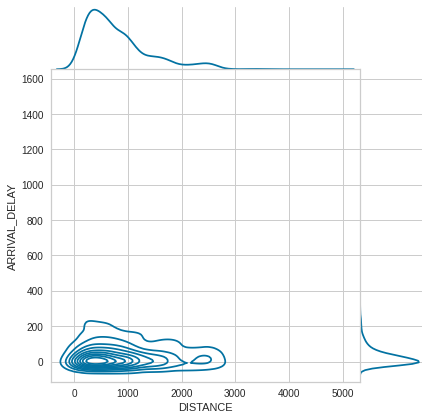

In [25]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot(x='DISTANCE', y='ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b');

## Scheduled Departure

<Figure size 1080x864 with 0 Axes>

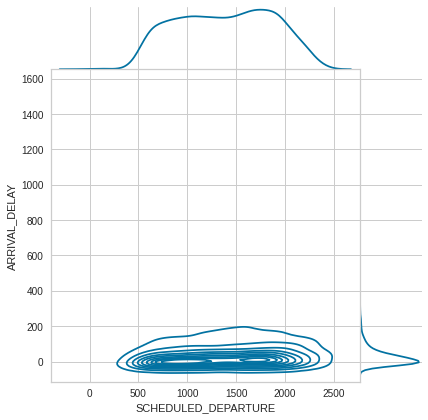

In [26]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot(x='SCHEDULED_DEPARTURE', y='ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b')

## Scheduled Arrival

<Figure size 1080x864 with 0 Axes>

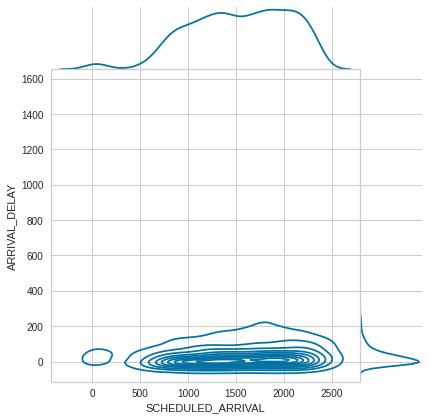

In [27]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot(x='SCHEDULED_ARRIVAL', y='ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b')

## Scheduled Time

<Figure size 1080x864 with 0 Axes>

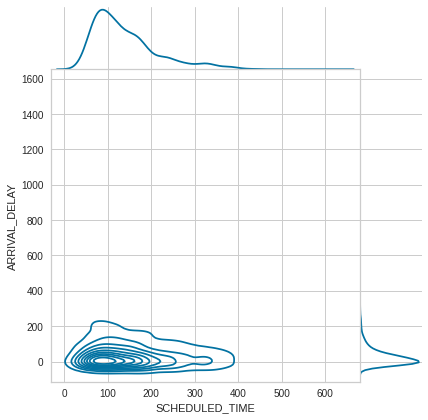

In [28]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot(x='SCHEDULED_TIME', y='ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b');

# Pipeline

In [29]:
featuresNumeric = [
    'DISTANCE',
    'SCHEDULED_DEPARTURE',
    'SCHEDULED_ARRIVAL',
    'SCHEDULED_TIME'
]
transformerNumeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
], verbose=True)


featuresCategorical = [
    'MONTH',
    'DAY_OF_WEEK',
    'AIRLINE',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT'
]
transformerCategorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(categories='auto', handle_unknown='ignore'))
], verbose=True)


preprocessor = ColumnTransformer(transformers=[
        ('num' , transformerNumeric,     featuresNumeric),
        ('cat' , transformerCategorical, featuresCategorical)
])

In [30]:
X = df.copy()
X = X.sample(frac=0.25, random_state=23)
X.MONTH       = X.MONTH.astype(str)
X.DAY_OF_WEEK = X.DAY_OF_WEEK.astype(str)
X.AIRLINE     = X.AIRLINE.astype(str)
X.ORIGIN_AIRPORT      = X.ORIGIN_AIRPORT.astype(str)
X.DESTINATION_AIRPORT = X.DESTINATION_AIRPORT.astype(str)
print(X.dtypes)

y = X.CLASS
X = X.drop(['CLASS', 'CANCELLED', 'ARRIVAL_DELAY'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = np.where(y_train == 'ONTIME', 0, 1)
y_test  = np.where(y_test  == 'ONTIME', 0, 1)

MONTH                   object
DAY_OF_WEEK             object
AIRLINE                 object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_ARRIVAL        int64
SCHEDULED_TIME         float64
DISTANCE                 int64
ARRIVAL_DELAY          float64
CANCELLED                int64
CLASS                   object
dtype: object


# Metrics

In [31]:
def measureErrors(y, y_hat):
    accuracy = accuracy_score(y, y_hat)
    print('Accuracy', accuracy)
    print('Confusion Matrix')
    print(confusion_matrix(y, yhat))
    print('Classification Report')
    print(classification_report(y_hat, y))
    return accuracy

In [32]:
results_df = pd.DataFrame(columns=['Accuracy'])

# Bagging vs Boosting 
* Bagging = Bootstrap Aggregating
 * Leverage high variance (overfitting) unstable learners
* Boosting
 * Combine high bias (underfitting) stable learnings 

## Data
* Bagging  - Each model pulls a random subsample of the entire dataset
* Boosting - Data is incrementally built giving more preference to misclassified datapoints


## Models
* Bagging
 * Each model gets an equal vote
 * Models can be built in parallel
* Boosting
 * Model is incrementally built
 * Model is sequentually built
 
https://bradzzz.gitbooks.io/ga-dsi-seattle/dsi/dsi_06_trees_methods/3.1-lesson/readme.html

![](https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_06_trees_methods/3.1-lesson/assets/images/BoostingVSBagging.png)

# Adaboost - Adaptive Boosting

![](https://miro.medium.com/max/850/1*DwvwMlOcT1T9hZwIJvMfng.png)

## Weak Learner
* Deault = DecisionTreeClassifier(max_depth=1)
* Best split chosen based on Information Gain 
 * Parent Entropy - Mean(Child Entropy)
* Plug in your own (SVC for example)
* Ever played Guess Who?

![](https://i.etsystatic.com/6017061/r/il/bc1fdb/882007787/il_570xN.882007787_9ggr.jpg)

## Algorithm

![](https://www.researchgate.net/profile/Gokhan-Tur/publication/224567440/figure/fig7/AS:668616156532759@1536421922787/AdaBoost-algorithm-for-the-binary-classification-task.png)

## Weighting
* Weighting - starts at 1/n for each
* Updated at each iteration
 * Correctly Classified = Lower Weight
 * Incorrectly Classified = Lower Weight

## Convergence
* After n Rounds of boosting
* Early Stopping
* Overfitting is a concern with boosting
  * Each iteration adds complexity to the model
  * A more complex model can fit not only "signal" but "noise"

![](https://bioinfo.iric.ca/wpbioinfo/wp-content/uploads/2017/10/error_curves.png)

# Learning

## Fit Model

In [33]:
ada = AdaBoostClassifier(n_estimators=50)
pipe = Pipeline([('pp', preprocessor),
                ('classifier', ada)])
pipe.fit(X_train, y_train)

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   0.6s


Pipeline(memory=None,
         steps=[('pp',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                       

## Predict Model

In [34]:
yhat = pipe.predict(X_test)

## Score Model

In [35]:
acc = measureErrors(y_test, yhat)
results_df.loc['AdaBoost'] = [acc]

Accuracy 0.6145
Confusion Matrix
[[14465 10534]
 [ 8741 16260]]
Classification Report
              precision    recall  f1-score   support

           0       0.58      0.62      0.60     23206
           1       0.65      0.61      0.63     26794

    accuracy                           0.61     50000
   macro avg       0.61      0.62      0.61     50000
weighted avg       0.62      0.61      0.61     50000



# Visualize

## Confusion Matrix

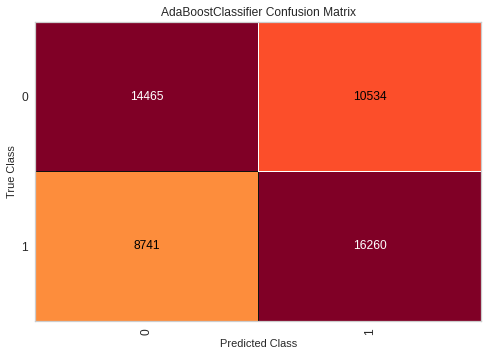

In [36]:
visualizer = ConfusionMatrix(pipe, is_fitted=True)
visualizer.score(X_test, y_test)
visualizer.poof()

## Classification Report

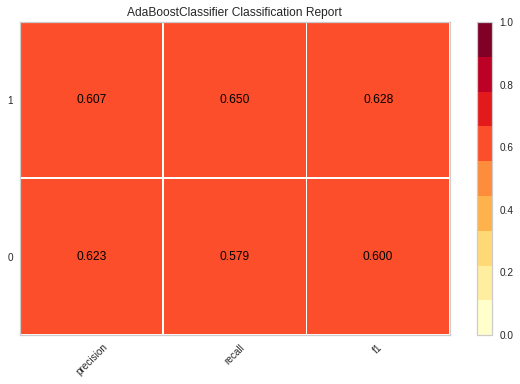

In [37]:
visualizer = ClassificationReport(pipe, is_fitted=True)
visualizer.score(X_test, y_test)
visualizer.poof()

# AdaBoost - Internals & Questions

## What is a weak learner?
* Should be better than a coin flip
* Implemented as a Decision Tree with max_depth = 1 (i.e. Decision Stump)
* Best stump is the one that maximizes information gain (i.e. minimizes entropy)

## How is each learner weighted?
* We use the number of samples correctly classified to compute the "amount of say"
* $ Significance = .5 * log( \frac{(1 - Error)}{(Error)} )$

## How do we reweight the samples?
* We want boosting to:
* Add weight to samples we get wrong 
  * $ New Weight = Prior Weight * e ^ {(Significance)} $
* Reduce weight on those we get right
  * $ New Weight = Prior Weight * e ^ {-(Significance)} $

## How does boosting handle outliers?
* Outliers can cause problems for boosting methods
* The algorithm can continue to put more and more weight on the outlier at the expense of generalization

## What hyper-parameters can we tune?
* Learning rate is (often) the most influential parameter
  * It affects the rate at which we make improvements
  *  Controls the contribution of the weak learners in the final combination
* The number of boosting rounds in equally important
  * Boosting may overfit if we allow it to fun too long
  * Run long enough, it can classify everything correctly